In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pytensor.tensor import math
from pytensor.ifelse import ifelse
from pytensor.tensor import TensorVariable
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import halfcauchy, expon, gamma
import pickle

In [ ]:
def logp_np(value, loc, scale, beta):
    return np.log(np.abs(beta)) + (beta-1)*np.log(value) - np.log(scale) - np.log(2*np.pi)/2 - (value**beta - loc)**2 / (2*scale**2)

def logp(value, loc, scale, beta):
    return pt.log(pt.abs(beta)) + (beta-1)*pt.log(value) - pt.log(scale) - pt.log(2*pt.pi)/2 - (value**beta - loc)**2 / (2*scale**2)

def random(loc, scale, beta, rng=None, size=None):
    if size is not None:
        assert size == loc.shape
    else:
        size = loc.shape

    return np.random.normal(loc=loc, scale=scale, size=size)**(1/beta)

In [ ]:
def transform_Y_to_X(y, s, B, delta, sigma):
  x = y ** (- B)
  a = (sigma ** 2) * (B ** 2) / 2.
  b = - B * delta
  c = (sigma ** 2 * B * (B + 1))/2. - (B * s)
  # t is not changed in this transformation

  return x, a, b, c

def transform_X_to_Z(x, t_diffs, a, b, c):
  """
  t_diffs is the absolute time between each observation.
  """
  z_t = (x[1:] / float(a)) * np.exp(- b * t_diffs)
  z_0 = x[:-1] / float(a)
  t_tilda_diffs = t_diffs if b == 0 else (1 - np.exp(- b*t_diffs)) / float(b)
  c_tilda = c / float(a)

  return z_t, z_0, t_tilda_diffs, c_tilda

def transform_Z_to_feller_params(z_t, z_0, t_tilda_diffs, c_tilda):

  x_ = z_t / t_tilda_diffs # Called 'x_' to distinguish from previous x
  lambda_ = z_0 / t_tilda_diffs
  nu = c_tilda - 1

  return x_, lambda_, nu

DEFAULT_N_TERMS = 20000

def logsumexp(array, axis=0):
  """
  Compute the log of the sum of exponentials of input elements while definitely
  avoiding overflow and avoiding as much underflow as possible.

  Credit to Roodman for implementation details.

  The scipy implementation seems to avoid underflow but not overflow.
  """
  # Define shift for each column that is just large enough to avoid overflow
  max_float = np.finfo(float).max
  n_terms_in_sum = array.shape[axis]
  shift = (np.log(max_float / n_terms_in_sum)
           - np.amax(array, axis=axis, keepdims=True) )

  # Compute logsumexp
  with np.errstate(divide='ignore'):
    diff = np.exp(array + shift)
    s = np.log(np.sum(diff, axis=axis))

  shift = np.squeeze(shift, axis=axis) # Return 1-d array
  return s - shift


def calculate_log_likelihood_terms(x_,
                                   lambda_,
                                   nu,
                                   n_terms=DEFAULT_N_TERMS,
                                   m_min=0):
  """
  Returns 1-d array of terms in equation 47. Each element gives the value of
  the RHS for a data point. These should be summed to give the overall
  likelihood of the data.

  n_terms indicates the number of terms of the sum to be computed, each
  corresponding to a different value of m.

  x_ and lambda_ are assumed to be 1-d numpy arrays, length n_data.
  """
  # Construct array of the shape parameters that are summed over in eq 47
  m_array = np.array([range(m_min, m_min + n_terms)]).transpose()

  if nu >= -1:
    first_term_arg = m_array + 1
    second_term_arg = m_array + nu + 1
  else:
    first_term_arg = m_array - nu + 1
    second_term_arg = m_array + 1

  # Note: first_term_arg and second_term_arg are 2-d arrays with shape
  # (n_terms, 1) but x_ and lambda_ are 1-d arrays with shape n_data_points.
  # When one each (e.g. first_term_arg and x_) are both used as inputs to a
  # numpy function, the results is 'broadcast' as a 2-d array with shape
  # (n_terms, n_data_points).

  # Get 2-d array of log-likelihoods
  ## each element gives the log-likelihood for a specific value of m and a
  # data point
  ln_first_term = gamma.logpdf(lambda_, first_term_arg)
  ln_second_term = gamma.logpdf(x_, second_term_arg)

  # Multiply together terms, as in eq 47, by adding log-likelihoods
  ln_rhs_matrix = ln_first_term + ln_second_term

  # Sum over the different terms to get array length n_data_points
  return logsumexp(ln_rhs_matrix, axis=0)

def sde_forward_density(At, A0, t, beta, theta, sigma):
  a = sigma**2 * beta**2 / 2
  b = 0
  c = beta*theta - sigma**2 * beta*(1-beta)/2

  X0 = A0**beta
  Xt = At**beta

  Z0 = X0/a
  Zt = Xt/a

  c_bar = c/a
  x = Zt/t
  lamb = Z0/t
  nu = c_bar - 1

  return ((beta * At**(beta-1))/(a*t)) * np.exp(calculate_log_likelihood_terms(x, lamb, nu))

In [ ]:
DEFAULT_N_TERMS = 20000

def gamma_log_density_pt(x, a):
  return -x + (a-1)*pt.log(x) - pt.log(math.gamma(a))

def logsumexp_pt(array, axis=0):
  """
  Compute the log of the sum of exponentials of input elements while definitely
  avoiding overflow and avoiding as much underflow as possible.

  Credit to Roodman for implementation details.

  The scipy implementation seems to avoid underflow but not overflow.
  """
  # Define shift for each column that is just large enough to avoid overflow
  max_float = np.finfo(float).max
  n_terms_in_sum = array.shape[axis]
  shift = (pt.log(max_float / n_terms_in_sum)
           - pt.max(array, axis=axis, keepdims=True) )

  # Compute logsumexp
  diff = pt.exp(array + shift)
  s = pt.log(pt.sum(diff, axis=axis))

  shift = pt.squeeze(shift, axis=axis) # Return 1-d array
  return s - shift


def calculate_log_likelihood_terms_pt(x_,
                                   lambda_,
                                   nu,
                                   n_terms=DEFAULT_N_TERMS,
                                   m_min=0):
  """
  Returns 1-d array of terms in equation 47. Each element gives the value of
  the RHS for a data point. These should be summed to give the overall
  likelihood of the data.

  n_terms indicates the number of terms of the sum to be computed, each
  corresponding to a different value of m.

  x_ and lambda_ are assumed to be 1-d numpy arrays, length n_data.
  """
  # Construct array of the shape parameters that are summed over in eq 47
  m_array = np.array([range(m_min, m_min + n_terms)], dtype=float).transpose()
  greater_than = pt.gt(nu, -1)

  first_term_arg = ifelse(greater_than, m_array + 1, m_array - nu + 1)
  second_term_arg = ifelse(greater_than, m_array + nu + 1, m_array + 1)

  # Note: first_term_arg and second_term_arg are 2-d arrays with shape
  # (n_terms, 1) but x_ and lambda_ are 1-d arrays with shape n_data_points.
  # When one each (e.g. first_term_arg and x_) are both used as inputs to a
  # numpy function, the results is 'broadcast' as a 2-d array with shape
  # (n_terms, n_data_points).

  # Get 2-d array of log-likelihoods
  ## each element gives the log-likelihood for a specific value of m and a
  # data point
  ln_first_term = gamma_log_density_pt(lambda_, first_term_arg)
  ln_second_term = gamma_log_density_pt(x_, second_term_arg)

  # Multiply together terms, as in eq 47, by adding log-likelihoods
  ln_rhs_matrix = ln_first_term + ln_second_term

  # Sum over the different terms to get array length n_data_points
  return logsumexp_pt(ln_rhs_matrix, axis=0)

def sde_forward_log_density_pt(At, A0, t, beta, theta, sigma):
  a = sigma**2 * beta**2 / 2
  b = 0
  c = beta*theta - sigma**2 * beta*(1-beta)/2

  X0 = A0**beta
  Xt = At**beta

  Z0 = X0/a
  Zt = Xt/a

  c_bar = c/a
  x = Zt/t
  lamb = Z0/t
  nu = c_bar - 1

  return calculate_log_likelihood_terms_pt(x, lamb, nu) + pt.log(beta) + (beta-1)*pt.log(At) - pt.log(a*t)

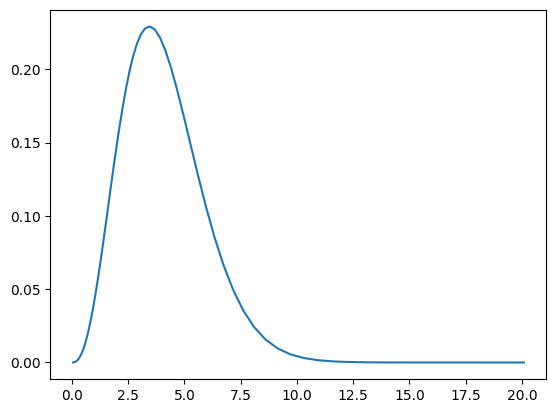

In [ ]:
a_range = np.exp(np.linspace(-3, 3, num=100))

plt.plot(a_range, sde_forward_density(a_range, A0=1, t=3, beta=1.5, theta=1.5, sigma=1))
plt.show()

In [ ]:
sde_forward_density(1, 2, 3, 2, 1, 1)

array([0.07178811])

In [ ]:
categories = {"CV + DL": ([0, 10], [1, 2**(12*10/9)], [111, 174, 505, 1446, 3564, 7821, 14147, 22062, 25758, 34543]), \
              "SAT": ([0, 21], [1, 2**(21/2)], [147, 175, 176, 229, 292, 389, 387, 445, 526, 484, 617, 560, 606, 644, 633, 709, 781, 709, 609, 701, 776, 655]), \
              "LP": ([0, 20], [1, 9], [1557, 1628, 1808, 1805, 2079, 2315, 2393, 2979, 3486, 3560, 4097, 4459, 5021, 5443, 5556, 5965, 6247, 6065, 6134, 6201, 6707]), \
              "Atari (RL)": ([0, 5], [1, 2**(5*12/11)], [3233, 4123, 6932, 12536, 20041])
}

#A_times = [0, 10]
#A = [1, 2**(12*10/9)]
#I = [111, 174, 505, 1446, 3564, 7821, 14147, 22062, 25758, 34543]

In [ ]:
print("Naive estimates:\n")

for category in categories:
  A_times, A, I = categories[category]
  gI = np.log(I[A_times[1]-1]/I[A_times[0]])/(A_times[1] - A_times[0] - 1)
  gA = np.log(A[-1]/A[0])/(A_times[1] - A_times[0])

  print("%s: %.4f" % (category, gA/gI))

Naive estimates:

CV + DL: 1.4490
SAT: 4.1662
LP: 1.5104
Atari (RL): 1.6579


In [ ]:
idata_dict = dict()
rng = np.random.default_rng(42)

for category in categories:
  A_times, A, I = categories[category]

  with pm.Model() as model:
    lambda_var = pm.HalfCauchy("lambda_var", beta=1)
    beta_var = pm.HalfCauchy("beta_var", beta=1)
    sigma_s = pm.HalfCauchy("annual_log_noise_var", beta=1)
    theta_s = sigma_s**2 * pt.maximum(1-beta_var, 0)/2 + pm.HalfCauchy("log_growth_var", beta=1)

    gI = np.log(I[A_times[1]-1]/I[A_times[0]])/(A_times[1] - A_times[0] - 1)
    delta_t_s = (gI*lambda_var/beta_var)**(-1)

    theta = theta_s/(A[0]**(-beta_var) * I[0]**lambda_var * delta_t_s)
    sigma = sigma_s/(A[0]**(-beta_var/2) * I[0]**(lambda_var/2) * delta_t_s**(1/2))

    I_integral = 0

    efficiency_increments = []
    for i in range(len(A_times) - 1):
      I_integral = sum([I[j]**lambda_var for j in range(A_times[i], A_times[i+1])])
      efficiency_increments.append(pm.CustomDist("efficiency_increment_" + str(i), A[i], I_integral, beta_var, theta, sigma, logp=sde_forward_log_density_pt, observed=A[i+1]))

    idata = pm.sample(draws=45000, tune=5000, cores=2, chains=20, progressbar=True, step=pm.DEMetropolis(), random_seed=rng)
    #idata = pm.sample(cores=2, chains=4, target_accept=0.8)
    idata_dict[category] = idata
    #var_data = pm.fit(n=10**4, method="svgd", callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")])

Category: CV + DL
Category: SAT
Category: LP
Category: Atari (RL)


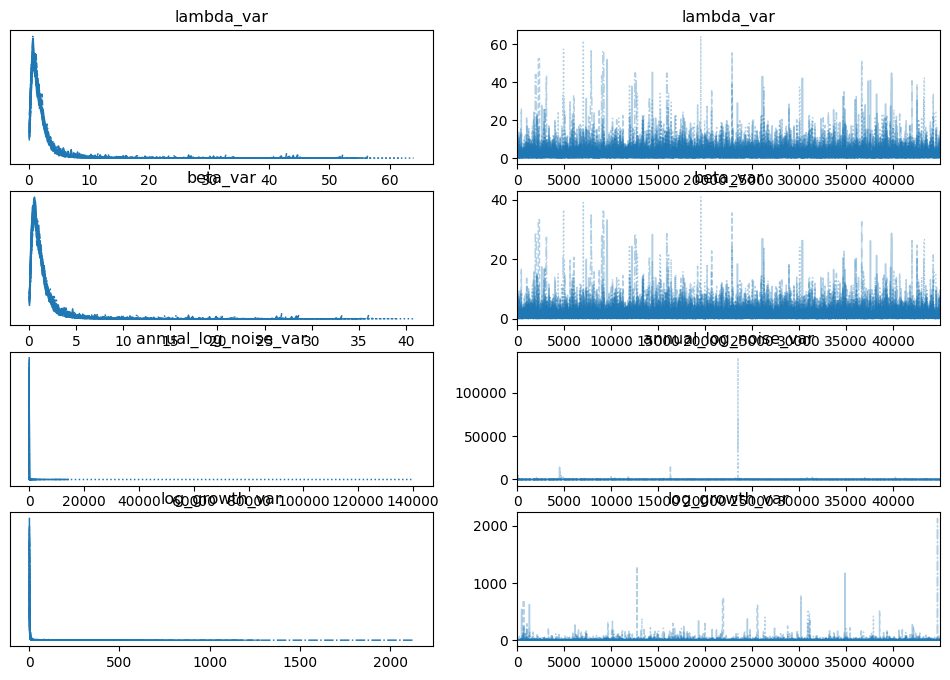

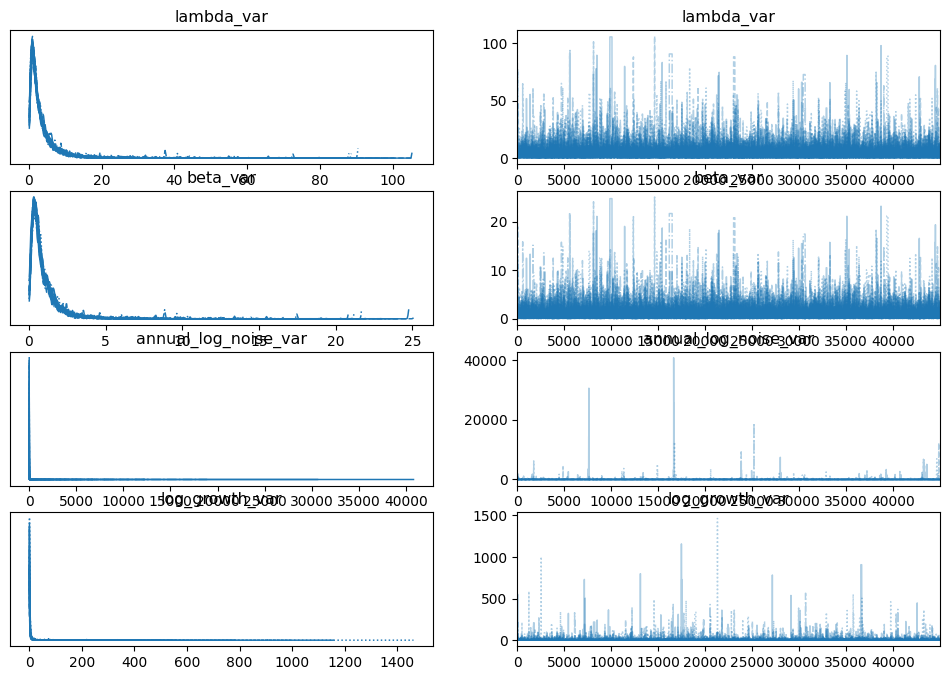

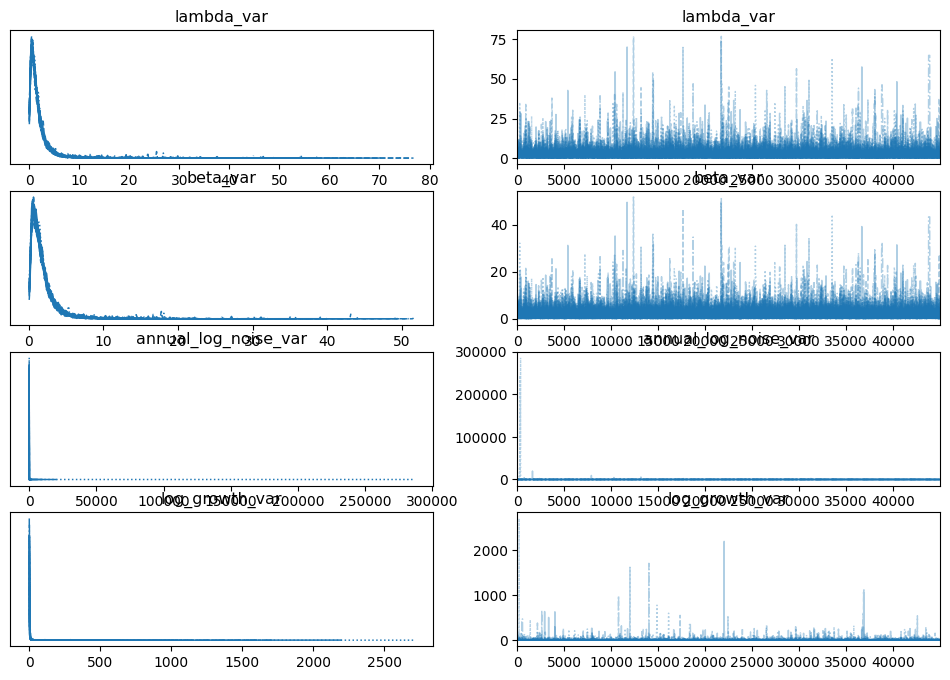

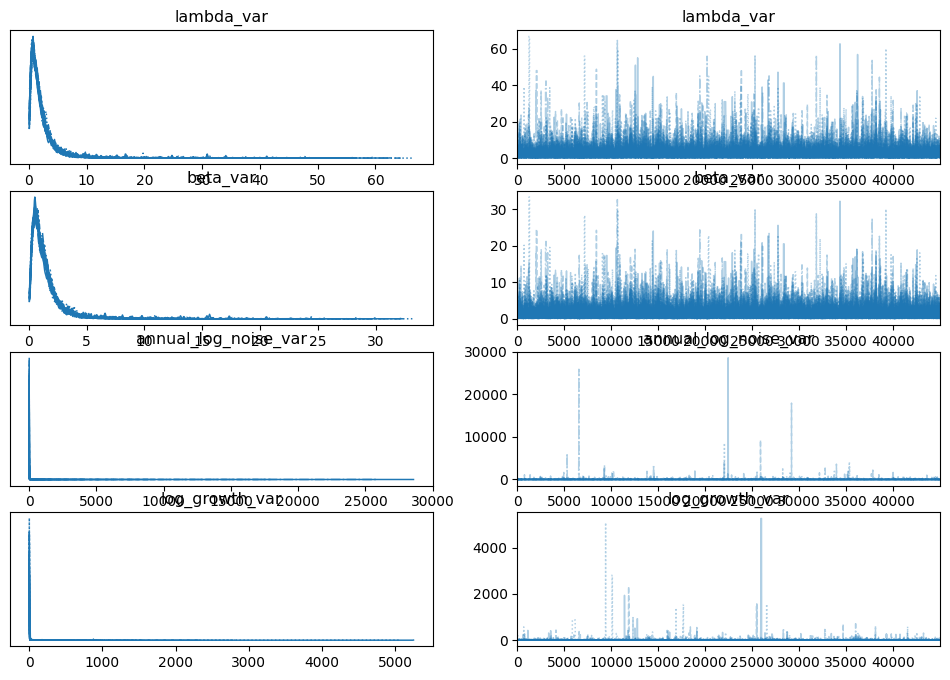

In [ ]:
for category in idata_dict:
  print("Category: %s" % (category))
  az.plot_trace(idata_dict[category])

In [ ]:
r_vals_dict = {}

for category in idata_dict:
  print("Category: %s" % (category))
  idata = idata_dict[category]
  samples = az.extract(idata)
  lambda_arr = samples.lambda_var.values
  beta_arr = samples.beta_var.values

  n = len(beta_arr)

  r_prior = expon.rvs(scale=1, size=n)/expon.rvs(scale=1, size=n)
  r_vals = lambda_arr/beta_arr

  r_vals_dict[category] = r_vals

  #print(np.percentile(r_prior, 5), np.percentile(r_prior, 25), np.percentile(r_prior, 50), np.percentile(r_prior, 75), np.percentile(r_prior, 95))
  #print(np.mean(r_vals), np.std(r_vals), np.exp(np.mean(np.log(r_vals))), np.exp(np.std(np.log(r_vals))))
  print("Beta percentiles: %.3f (%.3f to %.3f)" % (np.percentile(beta_arr, 50), np.percentile(beta_arr, 5), np.percentile(beta_arr, 95)))
  print("")

  print("Lambda percentiles: %.3f (%.3f to %.3f)" % (np.percentile(lambda_arr, 50), np.percentile(lambda_arr, 5), np.percentile(lambda_arr, 95)))
  print("")

  print("Return percentiles: %.3f %.3f %.3f %.3f %.3f" % (np.percentile(r_vals, 5), np.percentile(r_vals, 25), np.percentile(r_vals, 50), np.percentile(r_vals, 75), np.percentile(r_vals, 95)))
  print("\n----\n")

Category: CV + DL
Beta percentiles: 0.985 (0.224 to 4.050)

Lambda percentiles: 1.410 (0.290 to 6.021)

Return percentiles: 0.821 1.243 1.437 1.597 2.420

----

Category: SAT
Beta percentiles: 0.648 (0.139 to 2.891)

Lambda percentiles: 2.143 (0.387 to 11.312)

Return percentiles: 1.279 2.642 3.542 4.230 6.897

----

Category: LP
Beta percentiles: 1.290 (0.254 to 4.953)

Lambda percentiles: 1.259 (0.222 to 5.772)

Return percentiles: 0.245 0.681 1.077 1.508 3.095

----

Category: Atari (RL)
Beta percentiles: 1.023 (0.212 to 3.914)

Lambda percentiles: 1.482 (0.266 to 6.650)

Return percentiles: 0.459 1.103 1.583 2.014 3.673

----



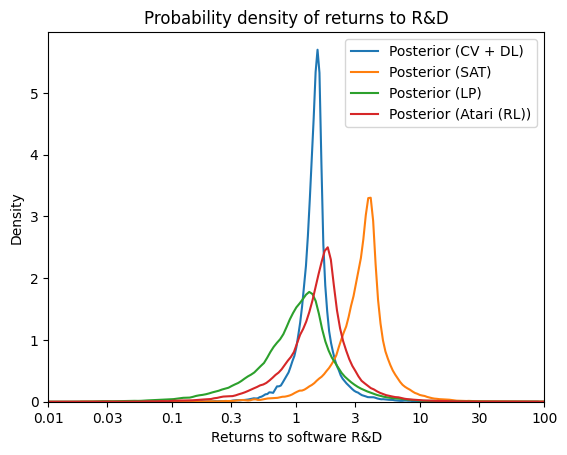

In [ ]:
for category in r_vals_dict:
  sns.kdeplot(np.log10(r_vals_dict[category]), label="Posterior (%s)" % (category))

#sns.kdeplot(np.log10(r_prior), label="Prior")

plt.xlim(-2, 2)

tick_list = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
plt.xticks(np.log10(np.array(tick_list)), tick_list)

plt.legend()

plt.title("Probability density of returns to R&D")
plt.xlabel("Returns to software R&D")

plt.savefig("return_bayesian_update_roodman_all.pdf")
plt.show()


#cdf_r_range = 10**np.linspace(-1, 1, 100)
#plt.plot(np.log10(cdf_r_range), [len([r for r in r_vals if r < r_threshold])/len(r_vals) for r_threshold in cdf_r_range], label="Posterior CDF of returns")
#plt.plot(np.log10(cdf_r_range), [len([r for r in r_prior if r < r_threshold])/len(r_prior) for r_threshold in cdf_r_range], label="Prior CDF of returns")

#plt.xlim(-1, 1)

#tick_list = [0.1, 0.3, 1, 3, 10]
#plt.xticks(np.log10(np.array(tick_list)), tick_list)

#plt.title("CDF of returns to R&D in computer vision")
#plt.xlabel("Returns to software R&D")

#plt.savefig("return_bayesian_update_roodman_cv_cdf.pdf")
#plt.show()

<ipython-input-33-9f08ec0aa6c3>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Computer vision +\nDeep learning", "SAT solvers", "Linear\nprograms", "Atari\n(Reinforcement learning,\nSample efficiency)"])


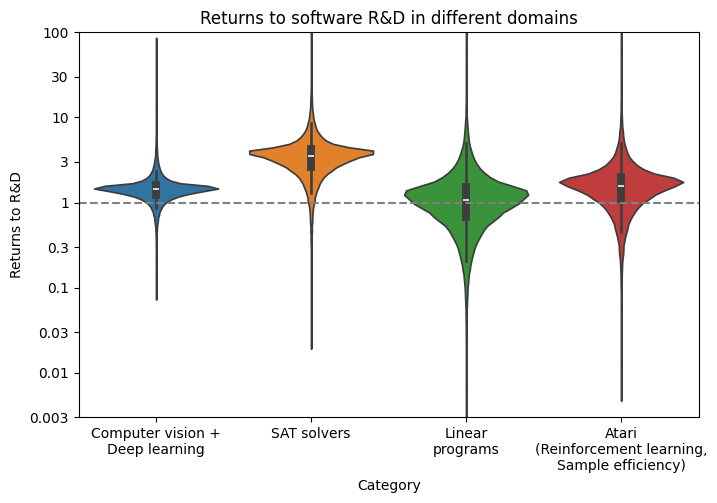

In [ ]:
violin_plot_list = []
for category in r_vals_dict:
  rl = np.percentile(r_vals_dict[category], 0.5)
  rh = np.percentile(r_vals_dict[category], 99.5)

  violin_plot_list.append(np.log10([r for r in r_vals_dict[category]]))

tick_list = [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

plt.figure(figsize=(8, 5))
ax = sns.violinplot(violin_plot_list)
#ax.set_xticklabels([category for category in r_vals_dict])
ax.set_xticklabels(["Computer vision +\nDeep learning", "SAT solvers", "Linear\nprograms", "Atari\n(Reinforcement learning,\nSample efficiency)"])
ax.set_yticks(np.log10(np.array(tick_list)), tick_list)
ax.set_ylim(np.log10(min(tick_list)), np.log10(max(tick_list)))\

#ax.axhline(0, color='black', alpha=0.3, linestyle='--')

ax.set_title("Returns to software R&D in different domains")
ax.set_ylabel("Returns to R&D")
ax.set_xlabel("Category")

#plt.grid(True)

plt.axhline(0, linestyle="dashed", color="gray")

plt.savefig("returns_violin_plot_v7.pdf")
plt.show()